In [10]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.datasets import load_digits

In [11]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.0,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.1, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

def var_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.var([data[v][x] for v in data])
    return arr

In [12]:
# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target
n_features = X.shape[1]
X_train, X_test = np.split(X, [1700])
y_train, y_test = np.split(y, [1700])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Random selection

In [13]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear', w1 = [0.8, 0.2]):
    data.kernel = kernel
    data.C = CVal
    with Pool(7) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

In [14]:
#RANDOM_SELECTION(1)

# SVM-RFE

In [15]:
@time_func
def SVM_RFE_W_STEP(mmode = 'const', step = 10, percentage = 0.5, C = 0.5, kernel = 'liblinear', w1 = [0.8, 0.2], gamma = 1.0, degree=6, mode='l1'):
    data.kernel = kernel
    #data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    data.degree = degree
    data.mode = mode
    kf = KFold(n_splits=18, shuffle=True)

    if mmode == 'const':
        index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe_vanilla, index)
    if mmode == 'multi':
        index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe_multi, index)

    #scores = list(map(data.svm_rfe_dynamic_step, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    #points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    points = {}
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    all_scores = [scal(x[1], w1)[2] for x in scores]
    err = np.std(all_scores, ddof=1) / np.sqrt(np.size(all_scores))
    print(np.mean(all_scores), err)

    print(mode, C, step)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), (np.mean(all_scores), err), time

0.09699888017917134 0.004703482832077988
l1 0.02 2


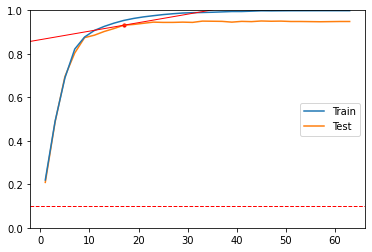

AT (17, 0.9317095931317656, 0.10775732549458752) WITH 0 ITERATIONS IN 1.8543758657243516 SECONDS : 0.015636646945166026
__main__.SVM_RFE_W_STEP - 00:00:17.573929000
0.09550337501555306 0.0038660512045766613
l2 0.02 2


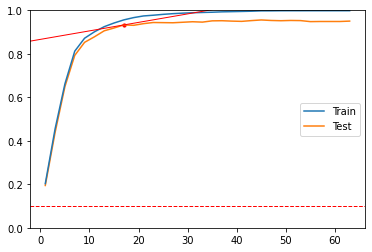

AT (17, 0.9329725021774296, 0.10674699825805636) WITH 0 ITERATIONS IN 1.9506422413720026 SECONDS : 0.011024556279230525
__main__.SVM_RFE_W_STEP - 00:00:19.178174700
0.09471001306457633 0.003696355563942058
l3 0.02 2


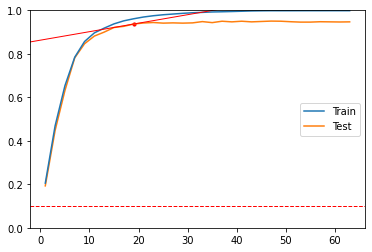

AT (19, 0.9371220604703248, 0.1096773516237402) WITH 0 ITERATIONS IN 1.8762077358033922 SECONDS : 0.02786688325289876
__main__.SVM_RFE_W_STEP - 00:00:17.054488200
0.14020156774916015 0.0051339710823244955
coef 0.02 2


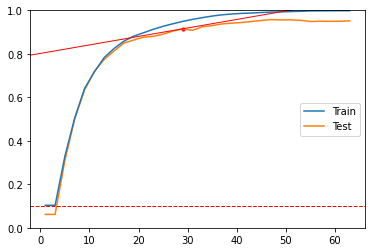

AT (29, 0.9152793330844844, 0.1584015335324125) WITH 0 ITERATIONS IN 2.5316050714916654 SECONDS : 0.03694300631066202
__main__.SVM_RFE_W_STEP - 00:00:18.803037500
0.10094827049894241 0.004694576881052038
l1 0.05 2


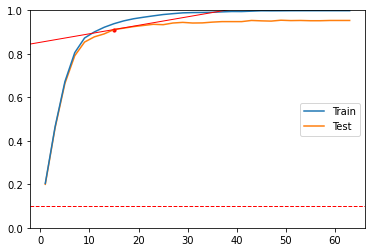

AT (15, 0.9117892248351374, 0.11744362013189012) WITH 0 ITERATIONS IN 2.249125255478753 SECONDS : 0.041576186899308844
__main__.SVM_RFE_W_STEP - 00:00:19.546264300
0.1026946466343163 0.0038586319739122637
l2 0.05 2


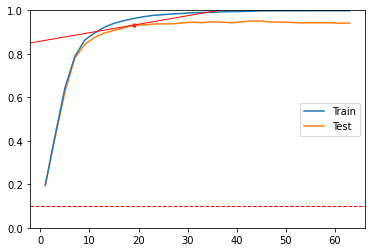

AT (19, 0.9323628219484882, 0.11348474244120946) WITH 0 ITERATIONS IN 2.236373941103617 SECONDS : 0.053204243744550204
__main__.SVM_RFE_W_STEP - 00:00:19.449745400
0.10168719671519223 0.006137892255379364
l3 0.05 2


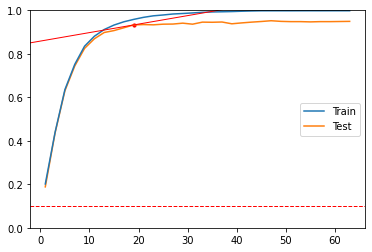

AT (19, 0.9329102899091699, 0.11304676807266409) WITH 0 ITERATIONS IN 2.214411828253004 SECONDS : 0.028278554135183504
__main__.SVM_RFE_W_STEP - 00:00:19.629828000
0.13250264402140102 0.004463783830173376
coef 0.05 2


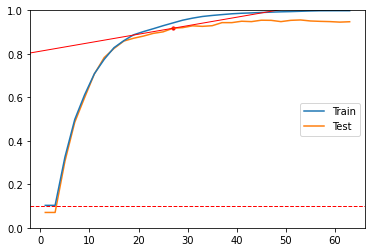

AT (27, 0.9176807266392932, 0.1502304186885654) WITH 0 ITERATIONS IN 2.6647483242882624 SECONDS : 0.05919323260160368
__main__.SVM_RFE_W_STEP - 00:00:19.464391400
0.1023468022894115 0.004801215813009276
l1 0.1 2


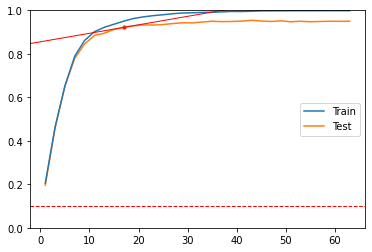

AT (17, 0.9217805151175811, 0.11570058790593514) WITH 0 ITERATIONS IN 2.1855659749772816 SECONDS : 0.05876578042326178
__main__.SVM_RFE_W_STEP - 00:00:19.294584400
0.09410818713450292 0.0034672522236211425
l2 0.1 2


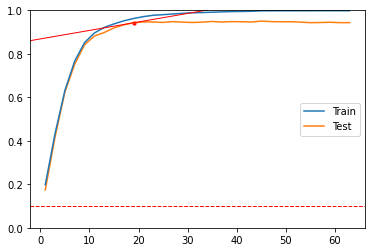

AT (19, 0.9429202438720916, 0.10503880490232673) WITH 0 ITERATIONS IN 2.238195194138421 SECONDS : 0.02955269603362513
__main__.SVM_RFE_W_STEP - 00:00:19.383006800
0.099096211272863 0.0030121127365355495
l3 0.1 2


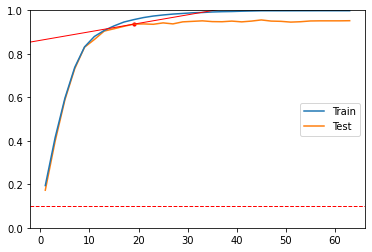

AT (19, 0.9364874953340797, 0.11018500373273624) WITH 0 ITERATIONS IN 2.2147776418262057 SECONDS : 0.03605756107487477
__main__.SVM_RFE_W_STEP - 00:00:19.226715000
0.13696754074903572 0.003397789223068364
coef 0.1 2


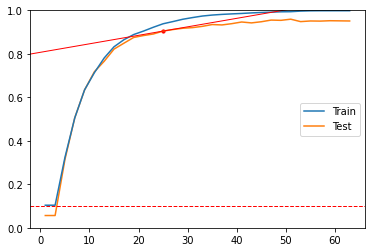

AT (25, 0.9047405748413586, 0.1543325401269131) WITH 0 ITERATIONS IN 2.713792165120443 SECONDS : 0.041436433472471085
__main__.SVM_RFE_W_STEP - 00:00:19.092830800
0.09976639293268633 0.00428874129476118
l1 0.2 2


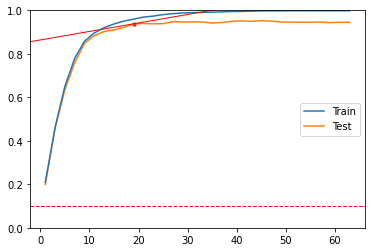

AT (19, 0.9382107751648626, 0.10880637986810991) WITH 0 ITERATIONS IN 2.239457686742147 SECONDS : 0.04049079959823606
__main__.SVM_RFE_W_STEP - 00:00:19.160891700
0.09817337003857161 0.0038151148921869954
l2 0.2 2


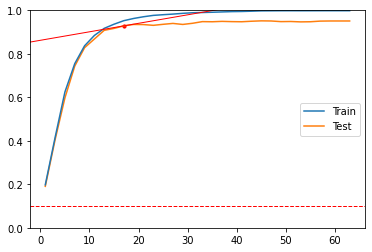

AT (17, 0.9287296254821451, 0.11014129961428393) WITH 0 ITERATIONS IN 2.2452727291319103 SECONDS : 0.040035621729361606
__main__.SVM_RFE_W_STEP - 00:00:19.148224900
0.0997617270125669 0.0034123760209972044
l3 0.2 2


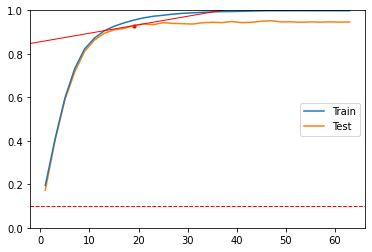

AT (19, 0.9299552071668534, 0.11541083426651727) WITH 0 ITERATIONS IN 2.4094361861546836 SECONDS : 0.012900471418644897
__main__.SVM_RFE_W_STEP - 00:00:20.405287100
0.1302993187756626 0.003964935558813653
coef 0.2 2


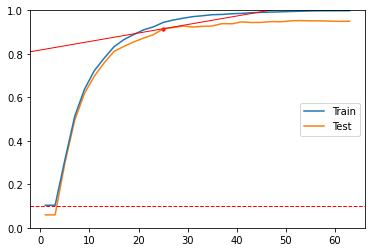

AT (25, 0.9153291028990918, 0.1458617176807266) WITH 0 ITERATIONS IN 3.0281915267308555 SECONDS : 0.09399950822741862
__main__.SVM_RFE_W_STEP - 00:00:20.687470700
0.09782855854174444 0.0036507871800011043
l1 0.5 2


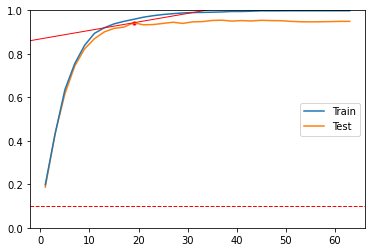

AT (19, 0.9429264650989175, 0.10503382792086599) WITH 0 ITERATIONS IN 2.4238792260487876 SECONDS : 0.023313291016304704
__main__.SVM_RFE_W_STEP - 00:00:20.144964000
0.09916301169590644 0.00491262802024824
l2 0.5 2


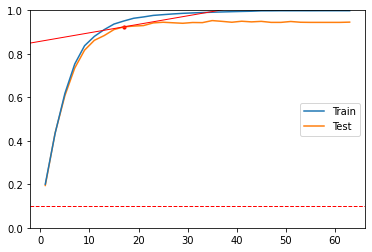

AT (17, 0.9241383600846087, 0.11381431193231305) WITH 0 ITERATIONS IN 2.3923252953423395 SECONDS : 0.03139279282321482
__main__.SVM_RFE_W_STEP - 00:00:20.111267000
0.10281704927211648 0.004653941311324318
l3 0.5 2


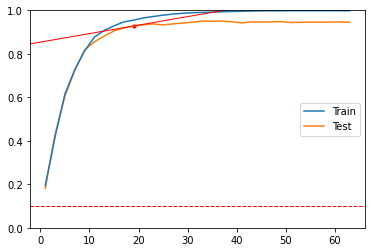

AT (19, 0.9282692546970261, 0.11675959624237908) WITH 0 ITERATIONS IN 2.4411094188690186 SECONDS : 0.032043512618025086
__main__.SVM_RFE_W_STEP - 00:00:19.945749600
0.1326853925594127 0.004533220103096947
coef 0.5 2


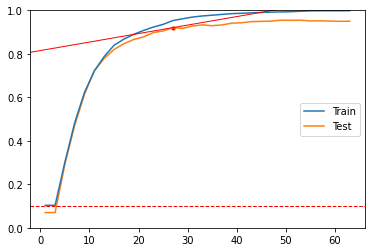

AT (27, 0.9205984820206545, 0.1478962143834764) WITH 0 ITERATIONS IN 3.530141976144579 SECONDS : 0.1263784553354042
__main__.SVM_RFE_W_STEP - 00:00:21.886250400
0.09902777777777778 0.0031814439860434317
l1 1 2


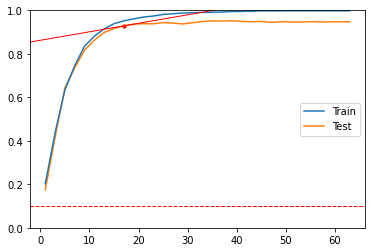

AT (17, 0.9288167226577081, 0.11007162187383354) WITH 0 ITERATIONS IN 2.691481113433838 SECONDS : 0.032122418723184235
__main__.SVM_RFE_W_STEP - 00:00:20.446113100
0.09830813736468832 0.0032816793890990043
l2 1 2


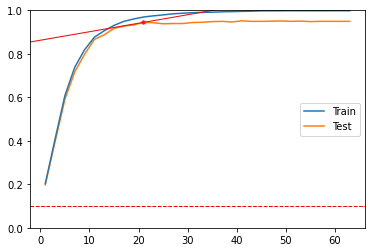

AT (21, 0.9447803906930446, 0.10980068744556429) WITH 0 ITERATIONS IN 2.700134383307563 SECONDS : 0.04823895939355618
__main__.SVM_RFE_W_STEP - 00:00:20.664235900
0.105487044295135 0.00387342081781081
l3 1 2


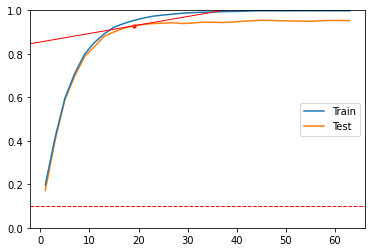

AT (19, 0.928835386338186, 0.11630669092945123) WITH 0 ITERATIONS IN 2.8229699664645724 SECONDS : 0.04736253043246124
__main__.SVM_RFE_W_STEP - 00:00:21.158921300
0.12829740574841358 0.004643935951880158
coef 1 2


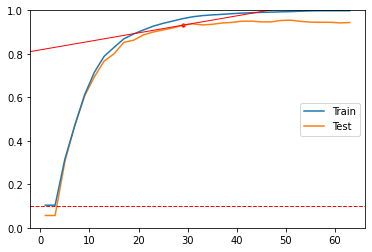

AT (29, 0.9317158143585915, 0.1452523485131268) WITH 0 ITERATIONS IN 4.472660210397509 SECONDS : 0.3749384560703747
__main__.SVM_RFE_W_STEP - 00:00:24.222562300
0.1024232456140351 0.0027849736496927337
l1 2 2


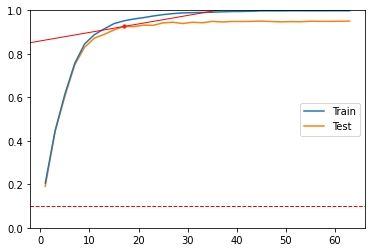

AT (17, 0.9259051885031728, 0.11240084919746174) WITH 0 ITERATIONS IN 3.159498453140259 SECONDS : 0.08160068947744195
__main__.SVM_RFE_W_STEP - 00:00:21.913026200
0.10335922918999627 0.003493000015387105
l2 2 2


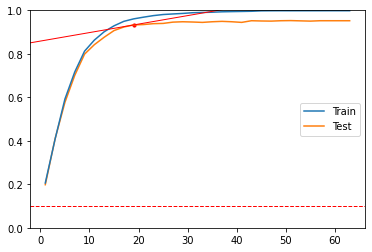

AT (19, 0.9329476172701257, 0.11301690618389948) WITH 0 ITERATIONS IN 3.32270258002811 SECONDS : 0.1632935064388701
__main__.SVM_RFE_W_STEP - 00:00:22.390352600
0.10142380552444945 0.0044773590870308974
l3 2 2


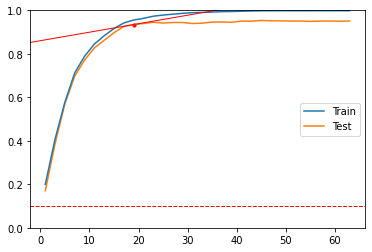

AT (19, 0.9347144456886899, 0.1116034434490481) WITH 0 ITERATIONS IN 3.41212797164917 SECONDS : 0.12435528463424185
__main__.SVM_RFE_W_STEP - 00:00:22.422265500
0.1314224057484136 0.004832881047455108
coef 2 2


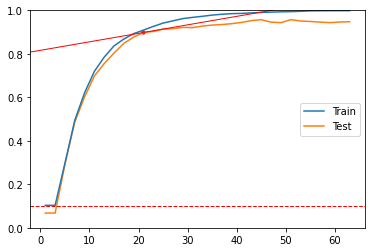

AT (21, 0.8982642777155656, 0.14701357782754754) WITH 0 ITERATIONS IN 6.263483179940118 SECONDS : 0.6390502045851729
__main__.SVM_RFE_W_STEP - 00:00:29.490269200


In [19]:
model_selection = {}
for C in [0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]:
    for mode in ['l1', 'l2', 'l3', 'coef']:
        model_selection[C, mode] = SVM_RFE_W_STEP('multi', C=C, step=2, mode=mode)

In [23]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.2f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {'l1': 1, 'l2': 2, 'l3': 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f} $\\pm$ {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[1][0], v[1][1])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.02} &    17 & 93.17\% & 0.097 $\pm$ 0.005 &    17 & 93.30\% & 0.096 $\pm$ 0.004 &    19 & 93.71\% & 0.095 $\pm$ 0.004\\
\textbf{0.05} &    15 & 91.18\% & 0.101 $\pm$ 0.005 &    19 & 93.24\% & 0.103 $\pm$ 0.004 &    19 & 93.29\% & 0.102 $\pm$ 0.006\\
\textbf{0.10} &    17 & 92.18\% & 0.102 $\pm$ 0.005 &    19 & 94.29\% & 0.094 $\pm$ 0.003 &    19 & 93.65\% & 0.099 $\pm$ 0.003\\
\textbf{0.20} &    19 & 93.82\% & 0.100 $\pm$ 0.004 &    17 & 92.87\% & 0.098 $\pm$ 0.004 &    19 & 93.00\% & 0.100 $\pm$ 0.003\\
\textbf{0.50} &    19 & 94.29\% & 0.098 $\pm$ 0.004 &    17 & 92.41\% & 0.099 $\pm$ 0.005 &    19 & 92.83\% & 0.103 $\pm$ 0.005\\
\textbf{1.00} &    17 & 92.88\% & 0.099 $\pm$ 0.003 &    21 & 94.48\% & 0.098 $\pm$ 0.003 &    19 & 92.88\% & 0.105 $\pm$ 0.004\\
\textbf{2.00} &    17 & 92.59\% & 0.102 $\pm$ 0.003 &    19 & 93.29\% & 0.103 $\pm$ 0.003 &    19 & 93.47\% & 0.101 $\pm$ 0.004\\


In [18]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {'l1': 1, 'l2': 2, 'coef': 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(v[1]/60, str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'